In [1]:
%%bash
# Do not change or modify this file
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=8af92e2e5c24c0027cbd53545d5bcb9c53209f6f93a4078e0e0850f0452cd8b3
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

MAX_MEMORY = "12g"

spark = SparkSession \
  .builder \
  .master("local[*]")\
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", MAX_MEMORY) \
  .config("spark.driver.memory", MAX_MEMORY)\
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size",MAX_MEMORY)\
  .getOrCreate()

sc = spark.sparkContext

In [3]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import clustering
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

In [4]:

%%bash
pip install pyspark

if [[ ! -f ./train.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
fi

if [[ ! -f ./test.csv ]]; then 
   wget https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/test.csv  
fi

--2020-11-29 17:04:16--  https://raw.githubusercontent.com/aatishsuman/health-insurance-cross-sell-prediction/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21432357 (20M) [text/plain]
Saving to: ‘train.csv’

     0K .......... .......... .......... .......... ..........  0% 3.98M 5s
    50K .......... .......... .......... .......... ..........  0% 9.48M 4s
   100K .......... .......... .......... .......... ..........  0% 4.86M 4s
   150K .......... .......... .......... .......... ..........  0% 16.1M 3s
   200K .......... .......... .......... .......... ..........  1% 7.11M 3s
   250K .......... .......... .......... .......... ..........  1% 27.3M 3s
   300K .......... .......... .......... .......... ..........  1% 26.3M 2s
   350K ...

In [5]:
grid_search = False

Load the train and test data into Spark Dataframes

In [6]:
train = spark.read.format("csv").option("header", "true").load("train.csv")
test = spark.read.format("csv").option("header", "true").load("test.csv")
train = train.drop('id')
test = test.drop('id')

Converting the numeric variables to double data type 

In [7]:
train = train.withColumn("AgeTemp", train["Age"].cast("double")).drop("Age").withColumnRenamed("AgeTemp", "Age")
train = train.withColumn("DrivingTemp", train["Driving_License"].cast("double")).drop("Driving_License").withColumnRenamed("DrivingTemp", "Driving_License")
train = train.withColumn("Previously_InsuredTemp", train["Previously_Insured"].cast("double")).drop("Previously_Insured").withColumnRenamed("Previously_InsuredTemp", "Previously_Insured")
train = train.withColumn("Annual_PremiumTemp", train["Annual_Premium"].cast("double")).drop("Annual_Premium").withColumnRenamed("Annual_PremiumTemp", "Annual_Premium")
train = train.withColumn("Policy_Sales_ChannelTemp", train["Policy_Sales_Channel"].cast("double")).drop("Policy_Sales_Channel").withColumnRenamed("Policy_Sales_ChannelTemp", "Policy_Sales_Channel")
train = train.withColumn("VintageTemp", train["Vintage"].cast("double")).drop("Vintage").withColumnRenamed("VintageTemp", "Vintage")
train = train.withColumn("ResponseTemp", train["Response"].cast("double")).drop("Response").withColumnRenamed("ResponseTemp", "Response")
train = train.withColumn("Region_CodeTemp", train["Region_Code"].cast("double")).drop("Region_Code").withColumnRenamed("Region_CodeTemp", "Region_Code")
train = train.withColumn("ResponseTemp", train["Response"].cast("double")).drop("Response").withColumnRenamed("ResponseTemp", "Response")

In [8]:
train.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Driving_License: double (nullable = true)
 |-- Previously_Insured: double (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: double (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Response: double (nullable = true)



In [9]:
train.select('Region_Code').distinct().show()
train.select('Vehicle_Age').distinct().show()
train.select('Policy_Sales_Channel').distinct().show()

+-----------+
|Region_Code|
+-----------+
|        8.0|
|        0.0|
|        7.0|
|       49.0|
|       29.0|
|       47.0|
|       42.0|
|       44.0|
|       35.0|
|       18.0|
|       39.0|
|        1.0|
|       37.0|
|       34.0|
|       25.0|
|       36.0|
|       41.0|
|        4.0|
|       23.0|
|       50.0|
+-----------+
only showing top 20 rows

+-----------+
|Vehicle_Age|
+-----------+
|  > 2 Years|
|   < 1 Year|
|   1-2 Year|
+-----------+

+--------------------+
|Policy_Sales_Channel|
+--------------------+
|               147.0|
|               160.0|
|                 8.0|
|                67.0|
|                70.0|
|                69.0|
|                 7.0|
|               154.0|
|               112.0|
|               124.0|
|               128.0|
|               108.0|
|               133.0|
|                88.0|
|                49.0|
|               155.0|
|               101.0|
|               116.0|
|                98.0|
|                29.0|
+---------

 **Phase 1 : Without Oversampling**

Feature Engineering 

In [10]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['Yes', 'No'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

policy_si = feature.StringIndexer(inputCol='Policy_Sales_Channel', outputCol='policy_col2', handleInvalid='skip')
policy_one_hot = feature.OneHotEncoder(inputCol='policy_col2',outputCol = "One Hot Policy")

feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si, policy_si,policy_one_hot])

train_xformed = feature_engineering_pipe.fit(train).transform(train) \
.drop('Gender','Vehicle_Age','Vehicle_Damage','Vintage','Policy_Sales_Channel','policy_col2','Region_Code') \
.withColumnRenamed("indexedGender",'Gender') \
.withColumnRenamed("indexedVehicle_Age",'Vehicle_Age') \
.withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage') \


train_xformed.show()

+----+---------------+------------------+--------------+--------+------+-----------+--------------+----------------+
| Age|Driving_License|Previously_Insured|Annual_Premium|Response|Gender|Vehicle_Age|Vehicle_Damage|  One Hot Policy|
+----+---------------+------------------+--------------+--------+------+-----------+--------------+----------------+
|44.0|            1.0|               0.0|       40454.0|     1.0|   0.0|        2.0|           0.0| (154,[1],[1.0])|
|76.0|            1.0|               0.0|       33536.0|     0.0|   0.0|        1.0|           1.0| (154,[1],[1.0])|
|47.0|            1.0|               0.0|       38294.0|     1.0|   0.0|        2.0|           0.0| (154,[1],[1.0])|
|21.0|            1.0|               1.0|       28619.0|     0.0|   0.0|        0.0|           1.0| (154,[0],[1.0])|
|29.0|            1.0|               1.0|       27496.0|     0.0|   1.0|        0.0|           1.0| (154,[0],[1.0])|
|24.0|            1.0|               0.0|        2630.0|     0.0

Train test Split 

In [11]:
train_df, validation_df = train_xformed.randomSplit([0.9, 0.1], 42)

Scaling numerical features and combining all features 

In [12]:
numerical_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['Age','Annual_Premium'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures")])
all_features = Pipeline(stages=[numerical_features,
                               feature.VectorAssembler(inputCols=['scaledFeatures'] + train_xformed.drop('Age','Annual_Premium','Response').columns,outputCol = 'features')
                               ])



Base Model 

In [13]:
lr = classification.LogisticRegression(labelCol='Response')
final_model_pipeline = Pipeline(stages=[all_features, lr])
initial_model = final_model_pipeline.fit(train_df)
predictions = initial_model.transform(validation_df)
evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')
print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))
accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Validation set Accuracy : ",accuracy)



Validation AreaUnderPR 0.33473955917748527
Validation set Accuracy :  0.8751268507194713


Cross Validation 

In [14]:
if grid_search:
  paramGrid = ParamGridBuilder() \
      .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
      .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
      .build()

  crossval = CrossValidator(estimator=final_model_pipeline, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=evaluator, 
                            numFolds=2)

  final_model_fitted = crossval.fit(train_df)
  predictions = final_model_fitted.transform(validation_df)

  accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
  print("Accuracy : ",accuracy)

Final model 

In [19]:
lr = classification.LogisticRegression(labelCol='Response', elasticNetParam= 0.0 , regParam= 0.001)

final_model_pipeline = Pipeline(stages=[feature.VectorAssembler(inputCols= train_df.drop('Response').columns,outputCol = 'features' ), lr])



initial_model = final_model_pipeline.fit(train_df)

predictions = initial_model.transform(validation_df)

evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')

print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))

accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Validation AreaUnderPR 0.335138046954803
Accuracy :  0.8751268507194713


In [20]:
lrm = initial_model.stages[-1]
transformed =  initial_model.transform(train_df)
from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*transformed
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))


data = [(name, abs(lrm.coefficients[idx])) for idx, name in attrs]

df = pd.DataFrame(data, columns =['Feature', 'Coefficient'])
display(df)

,Feature,Coefficient
0,Age,0.023931
1,Driving_License,1.299551
2,Previously_Insured,2.912497
3,Annual_Premium,0.000003
4,Gender,0.057505
...,...,...
156,One Hot Policy_143.0,3.508266
157,One Hot Policy_144.0,0.935498
158,One Hot Policy_149.0,4.563618
159,One Hot Policy_41.0,0.992173


In [21]:
df = df.sort_values('Coefficient', ascending=False)
display(df)

,Feature,Coefficient
160,One Hot Policy_43.0,6.424093
158,One Hot Policy_149.0,4.563618
138,One Hot Policy_67.0,4.267371
140,One Hot Policy_70.0,4.124948
149,One Hot Policy_34.0,4.071211
...,...,...
25,One Hot Policy_1.0,0.019603
56,One Hot Policy_21.0,0.017041
127,One Hot Policy_87.0,0.003572
3,Annual_Premium,0.000003


**Phase 2: With Oversampling**
Modeling process: 
1. Detailed graphical analysis of Region_Code, Policy_Sales_Channel and Vintage variables. 
2. Feature Engineering 
3. Fit LR using best hyper parameter values 
4. Evaluate.

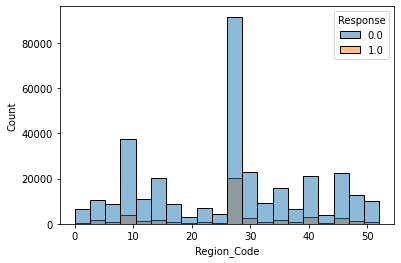

In [22]:
plot_df = train.toPandas()
ax = sns.histplot(x="Region_Code",  hue="Response", data= plot_df, bins= 20)


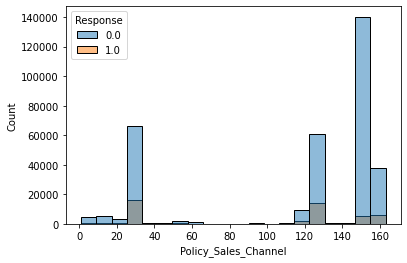

In [23]:

ax = sns.histplot(x="Policy_Sales_Channel",  hue="Response", data= plot_df, bins= 20)



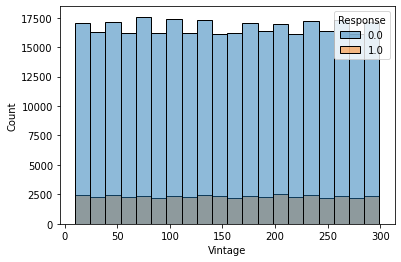

In [24]:
ax = sns.histplot(x="Vintage",  hue="Response", data= plot_df, bins= 20)



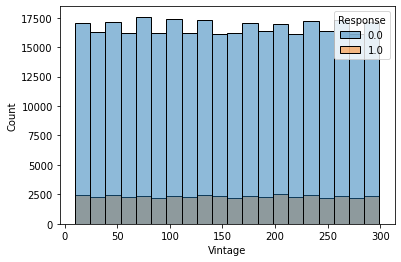

In [25]:
ax = sns.histplot(x="Vintage",  hue="Response", data= plot_df, bins= 20)

From the above two graphs we can see that the Vintage has equal proportion of Response labels no matter used as it is or binned. Moreover the base model coefficient analysis shows that the variable is insignificant even without oversampling.  Hence dropping vintage in the following feature engineering pipeline. 

In [26]:
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexerModel

gender_si = StringIndexerModel.from_labels(['Male', 'Female'],
                                    inputCol="Gender",
                                    outputCol="indexedGender")

Vehicle_Age_si = StringIndexerModel.from_labels(['< 1 Year','1-2 Year', '> 2 Years'],
                                    inputCol="Vehicle_Age",
                                    outputCol="indexedVehicle_Age")

Vehicle_Damage_si = StringIndexerModel.from_labels(['Yes', 'No'],
                                    inputCol="Vehicle_Damage",
                                    outputCol="indexedVehicle_Damage")

age_bin = feature.Bucketizer(splits=[0, 35, 65, 100], inputCol='Age',outputCol= 'Age_bin')

policy_si = feature.StringIndexer(inputCol='Policy_Sales_Channel', outputCol='policy_col2', handleInvalid='skip')
policy_one_hot = feature.OneHotEncoder(inputCol='policy_col2',outputCol = "One Hot Policy")

region_si = feature.StringIndexer(inputCol='Region_Code', outputCol='region_col2', handleInvalid='skip')
region_one_hot = feature.OneHotEncoder(inputCol='region_col2',outputCol = "One Hot Region")


feature_engineering_pipe = Pipeline(stages=[gender_si,Vehicle_Age_si,Vehicle_Damage_si,age_bin,policy_si,policy_one_hot,region_si,region_one_hot])


train_xformed = feature_engineering_pipe.fit(train).transform(train) \
.drop('Gender','Vehicle_Age','Vehicle_Damage','Vintage','Age','Policy_Sales_Channel','Region_Code','policy_col2','region_col2') \
.withColumnRenamed("indexedGender",'Gender') \
.withColumnRenamed("indexedVehicle_Age",'Vehicle_Age') \
.withColumnRenamed("indexedVehicle_Damage",'Vehicle_Damage') \


train_xformed.show()

+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|Driving_License|Previously_Insured|Annual_Premium|Response|Gender|Vehicle_Age|Vehicle_Damage|Age_bin|  One Hot Policy| One Hot Region|
+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|            1.0|               0.0|       40454.0|     1.0|   0.0|        2.0|           0.0|    1.0| (154,[1],[1.0])| (52,[0],[1.0])|
|            1.0|               0.0|       33536.0|     0.0|   0.0|        1.0|           1.0|    2.0| (154,[1],[1.0])| (52,[8],[1.0])|
|            1.0|               0.0|       38294.0|     1.0|   0.0|        2.0|           0.0|    1.0| (154,[1],[1.0])| (52,[0],[1.0])|
|            1.0|               1.0|       28619.0|     0.0|   0.0|        0.0|           1.0|    0.0| (154,[0],[1.0])| (52,[9],[1.0])|
|            1.0|               1.0|       27496

In [27]:
train_df, validation_df = train_xformed.randomSplit([0.9, 0.1], 42)

Finding the ratio of the response variable classes

In [28]:
from pyspark.sql.functions import col, explode, array, lit
major_df = train_df.filter(col("Response") == 0)
minor_df = train_df.filter(col("Response") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 7


Oversampling the minority class(1)

In [29]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
combined_df.show()

+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|Driving_License|Previously_Insured|Annual_Premium|Response|Gender|Vehicle_Age|Vehicle_Damage|Age_bin|  One Hot Policy| One Hot Region|
+---------------+------------------+--------------+--------+------+-----------+--------------+-------+----------------+---------------+
|            0.0|               0.0|        2630.0|     0.0|   0.0|        1.0|           0.0|    1.0| (154,[1],[1.0])| (52,[0],[1.0])|
|            0.0|               0.0|        2630.0|     0.0|   0.0|        1.0|           0.0|    1.0| (154,[1],[1.0])| (52,[0],[1.0])|
|            0.0|               0.0|        2630.0|     0.0|   0.0|        1.0|           0.0|    1.0| (154,[1],[1.0])|(52,[31],[1.0])|
|            0.0|               0.0|        2630.0|     0.0|   0.0|        1.0|           0.0|    1.0| (154,[1],[1.0])|(52,[36],[1.0])|
|            0.0|               0.0|        2630

Cross validation model 

In [30]:
if grid_search:
  paramGrid = ParamGridBuilder() \
      .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
      .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
      .build()

  crossval = CrossValidator(estimator=final_model_pipeline, 
                            estimatorParamMaps=paramGrid, 
                            evaluator=evaluator, 
                            numFolds=2)

  final_model_fitted = crossval.fit(combined_df)
  predictions = final_model_fitted.transform(validation_df)

  predictions = final_model_fitted.transform(validation_df)
  accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
  print("Accuracy : ",accuracy)


Final Model 

In [31]:
lr = classification.LogisticRegression(labelCol='Response', elasticNetParam= 0.01 , regParam= 0.001)

final_model_pipeline = Pipeline(stages=[feature.VectorAssembler(inputCols= combined_df.drop('Response').columns,outputCol = 'features' ), lr])



initial_model = final_model_pipeline.fit(combined_df)

predictions = initial_model.transform(validation_df)

evaluator = evaluation.BinaryClassificationEvaluator(labelCol = 'Response',metricName='areaUnderPR')

print('Validation AreaUnderPR {}'.format(evaluator.evaluate(predictions)))

accuracy = predictions.filter(predictions.Response == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Validation AreaUnderPR 0.3265728784146292
Accuracy :  0.6937628477010747


Feature importance analysis 

In [32]:
lrm = initial_model.stages[-1]
transformed =  initial_model.transform(combined_df)
from itertools import chain

attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*transformed
        .schema[lrm.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))


data = [(name, abs(lrm.coefficients[idx])) for idx, name in attrs]

df = pd.DataFrame(data, columns =['Feature', 'Coefficient'])
display(df)

df = df.sort_values('Coefficient', ascending=False)
display(df)


,Feature,Coefficient
0,Driving_License,9.852163e-01
1,Previously_Insured,3.622832e+00
2,Annual_Premium,1.470942e-07
3,Gender,6.931294e-02
4,Vehicle_Age,2.587457e-01
...,...,...
208,One Hot Region_5.0,3.457714e-02
209,One Hot Region_1.0,5.512861e-01
210,One Hot Region_44.0,6.522155e-01
211,One Hot Region_42.0,5.305990e-01


,Feature,Coefficient
131,One Hot Policy_79.0,5.358788
158,One Hot Policy_149.0,5.283142
137,One Hot Policy_2.0,5.246600
138,One Hot Policy_67.0,5.232563
117,One Hot Policy_110.0,5.230108
...,...,...
46,One Hot Policy_19.0,0.000000
159,One Hot Policy_41.0,0.000000
157,One Hot Policy_144.0,0.000000
145,One Hot Policy_105.0,0.000000


**Conclusion from Logistic regression modeling**
1. Oversampling decreased the accuracy obviously but increased the area under PR but the model can be said to be well generalised. 
2. Encoding region sales and policy variables increased the accuracy by 1%. 
3. Feature importance shows that the policy that customer has is very important in predicting if the customer will buy the vehicle insuarance or not. 